# Baseline Model

We will first build some basic models.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from predict_test_data import predict_test_data
from sklearn.metrics import confusion_matrix
import itertools

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
train = pd.read_csv('../data/cleaned/train_final.csv')
test = pd.read_csv('../data/cleaned/test_final.csv')
wc_playoffs_train = pd.read_csv('../data/cleaned/wc_playoffs_final.csv')

In [3]:
train.columns

Index(['game_date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'country', 'neutral', 'overall_diff',
       'attack_away_defence_home_diff', 'attack_diff',
       'attack_home_defence_away_diff', 'defence_diff', 'midfield_diff',
       'rank_diff', 'prestige_diff', 'growth_diff', 'full_age_diff',
       'start_age_diff', 'value_euros_millions_diff',
       'wage_euros_thousands_diff', 'goalkeeper_overall_diff',
       'bup_dribbling_diff', 'bup_passing_diff', 'bup_speed_diff',
       'cc_crossing_diff', 'cc_passing_diff', 'cc_shooting_diff',
       'd_aggresion_diff', 'd_pressure_diff', 'd_width_diff', 'home_win',
       'gdp_diff', 'is_home', 'raw_gdp_diff', 'score_past_2_games_diff',
       'score_past_4_games_diff', 'y_rating',
       'score_conceded_past_1_games_diff', 'win_momentum_past_5_games_diff',
       'score_conceded_past_4_games_diff', 'wins_past_3_games_diff',
       'wins_past_5_games_diff', 'wins_home_against_away_1_games',
       'score_

In [4]:
test.columns

Index(['game_date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'country', 'neutral', 'overall_diff',
       'attack_away_defence_home_diff', 'attack_diff',
       'attack_home_defence_away_diff', 'defence_diff', 'midfield_diff',
       'rank_diff', 'prestige_diff', 'growth_diff', 'full_age_diff',
       'start_age_diff', 'value_euros_millions_diff',
       'wage_euros_thousands_diff', 'goalkeeper_overall_diff',
       'bup_dribbling_diff', 'bup_passing_diff', 'bup_speed_diff',
       'cc_crossing_diff', 'cc_passing_diff', 'cc_shooting_diff',
       'd_aggresion_diff', 'd_pressure_diff', 'd_width_diff', 'home_win',
       'home_win_no_pk', 'Group', 'gdp_diff', 'is_home', 'raw_gdp_diff',
       'score_past_2_games_diff', 'score_past_4_games_diff', 'y_rating',
       'score_conceded_past_1_games_diff', 'win_momentum_past_5_games_diff',
       'score_conceded_past_4_games_diff', 'wins_past_3_games_diff',
       'wins_past_5_games_diff', 'wins_home_against_aw

Our most basic model would be to just predict the majority class every time. In this case, `home_win` = 1 is the majority class. What are is the training accuracy from just doing this "prediction"? 

In [5]:
train['home_win'].value_counts()[1] / len(train)

0.43806009488666314

Pretty decent when we have 3 classes. What about the test accuracy? 

In [6]:
accuracy_score(test['home_win'], np.ones(len(test)))

0.421875

Still decent. Any model we build should be better than this test accuracy of just guessing.

Our baseline model will be pretty simple. We will utilize the differences in FIFA rankings, offense ratings, defense ratings, midfield ratings, overall ratings, and whether the home team is actually playing at home. We will make a train and validation set out of the original train set. 

In [7]:
train = train[['home_win', 'rank_diff', 'attack_diff', 'defence_diff', 'midfield_diff', 'overall_diff']]
test = test[['home_win', 'home_win_no_pk', 'rank_diff', 'attack_diff', 'defence_diff', 'midfield_diff', 'overall_diff']]
wc_train = wc_playoffs_train[['home_win', 'rank_diff', 'attack_diff', 'defence_diff', 'midfield_diff', 'overall_diff']]

In [8]:
np.random.seed(14)
X_train, X_validation = train_test_split(train, test_size = 0.2)
y_train = X_train['home_win'].ravel()
X_train = X_train.drop(['home_win'], axis = 1).values
y_validation = X_validation['home_win'].ravel()
X_validation = X_validation.drop(['home_win'], axis = 1).values
y_test = test['home_win'].ravel()
y_test_no_pk = test['home_win_no_pk'].ravel()
X_test = test.drop(['home_win', 'home_win_no_pk'], axis = 1).values
y_wc = wc_train['home_win'].ravel()
X_wc = wc_train.drop(['home_win'], axis = 1).values

In [9]:
# stores the score of each model
score = {}

We will first try out logistic regression. 

In [10]:
lr_model = LogisticRegressionCV(solver = 'lbfgs', max_iter = 5000, cv = 5, multi_class='multinomial').fit(X_train, y_train)

In [11]:
score["Logistic Regression"] = {}
score["Logistic Regression"]["model"] = lr_model
score["Logistic Regression"]["Train Score"] = lr_model.score(X_train, y_train)
score["Logistic Regression"]["Validation Score"] = lr_model.score(X_validation, y_validation)

print("Logistic Regression Train Score: {}".format(score["Logistic Regression"]["Train Score"]))
print("Logistic Regression Validation Score: {}".format(score["Logistic Regression"]["Validation Score"]))

Logistic Regression Train Score: 0.5128543177323666
Logistic Regression Validation Score: 0.5684210526315789


We will also try out Linear Discriminant Analysis. However, we need to first check whether the variances across the three outcomes are equal. 

In [12]:
train.groupby('home_win').var()

,rank_diff,attack_diff,defence_diff,midfield_diff,overall_diff
home_win,,,,,
-1,916.793268,40.858572,37.554931,38.133908,31.393396
0,960.540851,47.654088,43.559341,41.798216,36.158215
1,936.866455,49.295727,43.509512,42.634416,37.105145


Surprisingly, besides `rank_diff`, they are actually quite similar! 

In [13]:
lda_model = LinearDiscriminantAnalysis().fit(X_train, y_train)

In [14]:
score["LDA"] = {}
score["LDA"]["model"] = lda_model
score["LDA"]["Train Score"] = lda_model.score(X_train, y_train)
score["LDA"]["Validation Score"] = lda_model.score(X_validation, y_validation)
print("LDA Train Score: {}".format(score["LDA"]["Train Score"]))
print("LDA Validation Score: {}".format(score["LDA"]["Validation Score"]))

LDA Train Score: 0.5102175346077785
LDA Validation Score: 0.5578947368421052


We will also try out Quadratic Discriminant Analysis, which should perform similarly to LDA in this case due to the almost equal variances.

In [15]:
qda_model = QuadraticDiscriminantAnalysis().fit(X_train, y_train)

In [16]:
score["QDA"] = {}
score["QDA"]['model'] = qda_model
score["QDA"]["Train Score"] = qda_model.score(X_train, y_train)
score["QDA"]["Validation Score"] = qda_model.score(X_validation, y_validation)
print("QDA Train Score: {}".format(score["QDA"]["Train Score"]))
print("QDA Validation Score: {}".format(score["QDA"]["Validation Score"]))

QDA Train Score: 0.5102175346077785
QDA Validation Score: 0.5368421052631579


We will also try out Random Forest.

In [17]:
rf_params = {'bootstrap': [True, False],
     'max_depth': [3, 5, 10, 20, 30, 40, None],
'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 10, 20],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 50, 100, 200, 500]}

rf_model = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=rf_params,\
                                   n_iter=50, scoring='accuracy', n_jobs=-1, cv=5, verbose=1).fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   30.4s finished


In [18]:
score["Random Forest"] = {}
score["Random Forest"]['model'] = rf_model
score["Random Forest"]["Train Score"] = rf_model.score(X_train, y_train)
score["Random Forest"]["Validation Score"] = rf_model.score(X_validation, y_validation)
print("Random Forest Train Score: {}".format(score["Random Forest"]["Train Score"]))
print("Random Forest Validation Score {}".format(score["Random Forest"]["Validation Score"]))

Random Forest Train Score: 0.5115359261700725
Random Forest Validation Score 0.5552631578947368


Let's also not forget XGBoost.

In [19]:
xgb_params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
    }
xgb_model = RandomizedSearchCV(estimator=XGBClassifier(objective='multi:softmax', num_class = 3), param_distributions=xgb_params,\
                                   n_iter=50, scoring='accuracy', n_jobs=-1, cv=5, verbose=1).fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   17.9s finished


In [31]:
score["XGBoost"] = {}
score["XGBoost"]['model'] = xgb_model
score["XGBoost"]["Train Score"] = xgb_model.score(X_train, y_train)
score["XGBoost"]["Validation Score"] = xgb_model.score(X_validation, y_validation)
print("XGBoost Train Score: {}".format(score["XGBoost"]["Train Score"]))
print("XGBoost Validation Score {}".format(score["XGBoost"]["Validation Score"]))

XGBoost Train Score: 0.5095583388266315
XGBoost Validation Score 0.5578947368421052


In [21]:
df_result = pd.DataFrame(score).T

In [22]:
df_result

,Train Score,Validation Score,model
Logistic Regression,0.512854,0.568421,"LogisticRegressionCV(Cs=10, class_weight=None,..."
LDA,0.510218,0.557895,"LinearDiscriminantAnalysis(n_components=None, ..."
QDA,0.510218,0.536842,"QuadraticDiscriminantAnalysis(priors=None, reg..."
Random Forest,0.511536,0.555263,"RandomizedSearchCV(cv=5, error_score='raise-de..."
XGBoost,0.509558,0.557895,"RandomizedSearchCV(cv=5, error_score='raise-de..."


In [23]:
model_name = df_result['Validation Score'].astype(float).argmax()
print("We choose the final model to be the one with the highest validation score,\
 which is {} in this case".format(model_name))

We choose the final model to be the one with the highest validation score, which is Logistic Regression in this case


In [24]:
wc_model = LogisticRegressionCV(solver = 'lbfgs', max_iter = 5000, cv = 5, multi_class='multinomial').fit(X_wc, y_wc)
test_pred = predict_test_data(X_test, df_result.loc[model_name].model)
test_pred_playoff = predict_test_data(X_test, df_result.loc[model_name].model, False, wc_model)
test_score = accuracy_score(y_test, test_pred)
test_score_playoff = accuracy_score(y_test, test_pred_playoff)
test_score_no_pk = df_result.loc[model_name].model.score(X_test, y_test_no_pk)
print("For the best Model, {}, the test accuracy is {:.3f} at 90 mins".format(model_name, test_score_no_pk))
print("For the best Model, {}, the test accuracy is {:.3f} at end (Softmax)".format(model_name, test_score))
print("For the best Model, {}, the test accuracy is {:.3f} at end (WC Playoff Model)".format(model_name, test_score_playoff))

For the best Model, Logistic Regression, the test accuracy is 0.562 at 90 mins
For the best Model, Logistic Regression, the test accuracy is 0.594 at end (Softmax)
For the best Model, Logistic Regression, the test accuracy is 0.578 at end (WC Playoff Model)


Impressive! We now have an idea of what our more advanced model should hope to achieve. 

Let us do some quick analysis of the baseline model. First, let's see what exactly the model is getting wrong. 

In [25]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')


In [26]:
np.set_printoptions(precision=2)
train_cm = confusion_matrix(y_train, df_result.loc[model_name].model.predict(X_train))
test_cm =  confusion_matrix(y_test, test_pred)

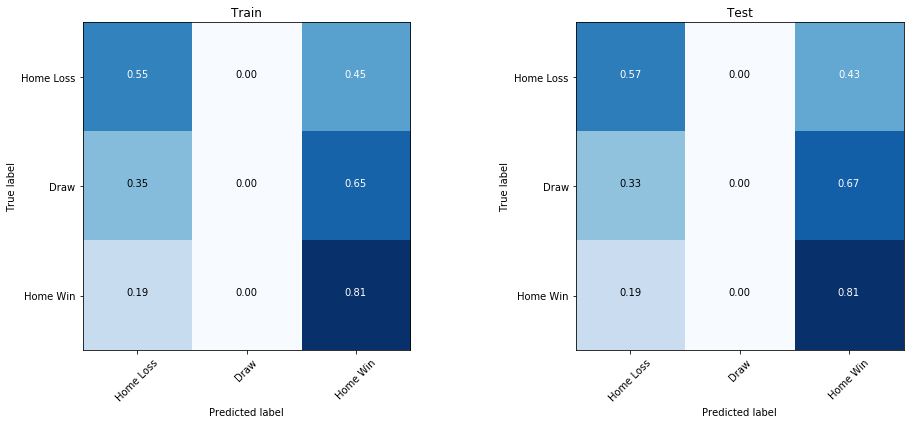

In [27]:
fig, axs = plt.subplots(1, 2, figsize = (14, 6))
plot_confusion_matrix(train_cm, ['Home Loss', 'Draw', 'Home Win'], axs[0], True, 'Train')
plot_confusion_matrix(test_cm, ['Home Loss', 'Draw', 'Home Win'], axs[1], True, 'Test')
plt.tight_layout()

Wow! Our model does not predict draws at all. This is a bit concerning, but it makes sense 

**RELATE BACK TO EDA**

We see that across train set and test set, the proportions in each entry of the confusion matrices are approximately the same, which is good. This might be an indication that our train and test sets are approximately similar. 

More importantly, we are curious just how important each feature is, especially the FIFA ranking feature, the one feature we are trying to replace. Feature importance of random forest allows us exactly to do so, and since it has similar performance to logistic regression in the train/validation set, we can utilize it in this case.

In [28]:
columns = np.array(['rank_diff', 'attack_diff', 'defence_diff', 'midfield_diff', 'overall_diff'])

In [29]:
feature_importances = rf_model.best_estimator_.feature_importances_

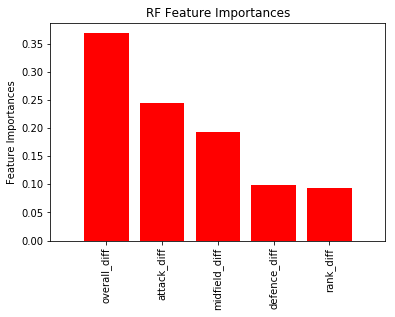

In [30]:
indices = np.argsort(feature_importances)[::-1]
plt.title("RF Feature Importances")
plt.bar(range(len(columns)), feature_importances[indices],
       color="r", align="center")
plt.xticks(range(len(columns)), columns[indices], rotation = 90)
plt.ylabel('Feature Importances')
plt.xlim([-1, len(columns)]);


It seems like the FIFA rankings is not that important of a feature! Hopefully we can make a better model than the baseline model.